In [1]:
#Short term fluctuations
!pip install pandas_datareader
!pip install google-api-python-client
!pip install yfinance
!pip install xgboost
!pip install ta
import ta
import pandas as pd
import requests
import time
import pandas_datareader.data as web
import datetime
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import xgboost as xgb
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'
import yfinance as yfin
yfin.pdr_override()

In [15]:
API_KEY = "1IZVEO8ZRLH6PJHZ"
#changeable stock
stock = "TSLA"
response = requests.get(f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={stock}&outputsize=full&apikey={API_KEY}")
data = response.json()

In [16]:
df = pd.DataFrame(data['Time Series (Daily)']).T
df = df.astype(float)
df

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
2023-06-05,217.80,221.2900,214.520,217.61,217.610000,151143052.0,0.0,1.0
2023-06-02,210.15,217.2500,209.752,213.97,213.970000,164398372.0,0.0,1.0
2023-06-01,202.59,209.8000,199.370,207.52,207.520000,148029931.0,0.0,1.0
2023-05-31,199.78,203.9500,195.120,203.93,203.930000,149356274.0,0.0,1.0
2023-05-30,200.10,204.4800,197.530,201.16,201.160000,128818746.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2010-07-06,20.00,20.0000,15.830,16.11,1.074000,6866900.0,0.0,1.0
2010-07-02,23.00,23.1000,18.710,19.20,1.280000,5139800.0,0.0,1.0
2010-07-01,25.00,25.9200,20.270,21.96,1.464000,8218800.0,0.0,1.0
2010-06-30,25.79,30.4192,23.300,23.83,1.588667,17187100.0,0.0,1.0


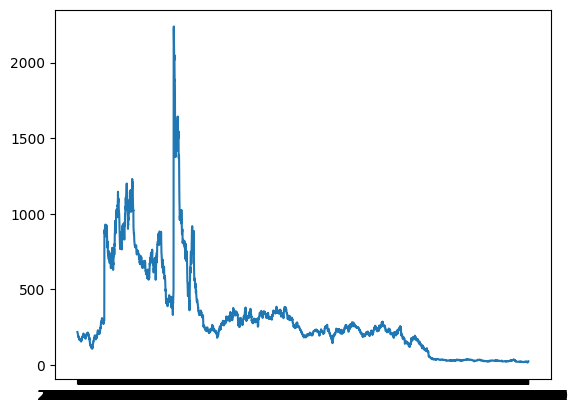

In [17]:
#Plot the closing price of Google (or whichever one)
plt.plot(df['4. close'])

In [18]:
df['Return'] = df['5. adjusted close'].pct_change(60).shift(-60)
df['RSI'] = ta.momentum.RSIIndicator(close=df['4. close'], window=14).rsi()
df['SMA'] = df['4. close'].rolling(window=20).mean()  
df['MACD'] = ta.trend.MACD(df['4. close']).macd()   
list_of_features = ['2. high', '3. low', '4. close', '5. adjusted close', '6. volume', 'SMA', 'RSI', 'MACD']
X = df[list_of_features]

y = np.where(df.Return > 0, 1, 0)
#df

In [19]:
#split data to see how good the decision tree will be
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 500)
#print sizes of the data
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

In [20]:
#treeClassifier = DecisionTreeClassifier('entropy', max_depth=4, min_samples_leaf=7)
#treeClassifier.fit(X_train, y_train)
xgb_Classifier = xgb.XGBClassifier(max_depth=3)
xgb_Classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
#y_pred = tree_Classifier.predict(X_test)
y_pred = xgb_Classifier.predict(X_test)

In [22]:
#Check performances
from sklearn.metrics import classification_report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       568
           1       0.80      0.80      0.80       409

    accuracy                           0.83       977
   macro avg       0.83      0.83      0.83       977
weighted avg       0.83      0.83      0.83       977



<Figure size 2400x5000 with 0 Axes>

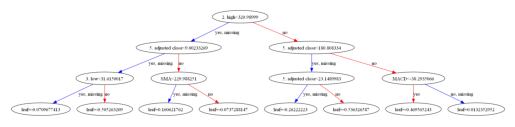

In [23]:
#View Tree
from sklearn import tree
import graphviz

plt.figure(figsize=(24, 50))
# Visualize a single tree using xgb.plot_tree()
xgb.plot_tree(xgb_Classifier, num_trees=0, max_depth=3)
plt.show()